In this notebook, we are going to build a neural network(multilayer perceptron) using TensorFlow and successfully train it to recognize digits in the image. Tensorflow is a very popular deep learning framework released by, and this notebook will guide for build a neural network with this library. If you want to understand what is a Multi-layer perceptron, you can look at my [previous notebook](https://github.com/aayushmnit/Deep_learning_explorations/blob/master/1_MLP_from_scratch/Building_neural_network_from_scratch.ipynb) where I built a Multi-layer perceptron from scratch using numpy. <br/>
Let's start by importing our data. As keras, a high-level deep learning library already has MNIST as part of their default data we are just going to import the dataset from there and split it into train and test set.

(50000, 28, 28) (50000,)


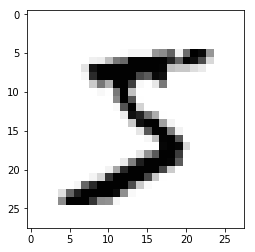

In [2]:
## Loading MNIST dataset from keras
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
## Printing dimensions
print(X_train.shape, y_train.shape)
## Visualizing the first digit
plt.imshow(X_train[0], cmap="Greys");

As we can see our current data have dimension N * 28*28, we will start by flattening the image in N*784, and one-hot encode our target variable.

In [3]:
## Changing dimension of input images from N*28*28 to  N*784
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)

## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train dimension:
(50000, 784)
Test dimension:
(10000, 784)
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


Now we have processed the data, let's start building our multi-layer perceptron using tensorflow. We will begin by importing the required libraries.

In [4]:
## Importing required libraries
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.InteractiveSession() 

_tf.InteractiveSession()_ is a way to run tensorflow model directly without instantiating a graph whenever we want to run a model. We will be building 784(Input)-512(Hidden layer 1)-256(Hidden layer 2)-10(Output) neural net model. Let's start our model construction by defining initialization variables.

In [5]:
## Defining various initialization parameters for 784-512-256-10 MLP model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1

In tensorflow, we define a placeholder for our input variables and output variables and any variables we want to keep track of.

In [6]:
# Placeholders for the input data
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.placeholder(tf.float32) 

As dense layers require weights and biases and they need to be initialized with a random normal distribution with zero mean and small variance (1/square root of the number of features).

In [7]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))

weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))

weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random_normal([num_output]))

Now we will start writing the graph calculation to develop our _784(Input)-512(Hidden layer 1)-256(Hidden layer 2)-10(Output) model_. We will multiply the input for each layer with its respective weights and add bias term. After weights and biases, we need to add an activation; we will use ReLU activation for hidden layers and softmax for the final output layer to get class probability score. Also to prevent overfitting; let 's add some drop out after each hidden layer. Dropout is an essential concept in creating redundancies in our network which leads to better generalization.

In [9]:
## Initializing weigths and biases
hidden_output_0 = tf.nn.relu(tf.matmul(input_X,weights_0)+bias_0)
hidden_output_0_0 = tf.nn.dropout(hidden_output_0, keep_prob)

hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.nn.dropout(hidden_output_1, keep_prob)

predicted_y = tf.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)

Now we need to define a loss function to optimize our weights and biases, and we will use softmax cross entropy with logits for the predicted and correct label. We will also add some L2 regularization to our network.

In [11]:
## Defining the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
        + regularizer_rate*(tf.reduce_sum(tf.square(bias_0)) + tf.reduce_sum(tf.square(bias_1)))

Now we need to define an optimizer and learning rate for our network to optimize weights and biases on our given loss function. We will use exponential decay on our learning rate by every five epoch to reduce the learning by 15%. For optimizer, we are going to use Adam optimizer.

In [ ]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

We are done with our model construction. Let's define accuracy metric to evaluate our model performance as loss function is non-intuitive.

In [8]:
## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

We will now start training our network on train data and evaluate our network on test dataset simultaneously. We will be using batch optimization with size 128 and train it for 14 epochs to get 98%+ accuracy.

In [10]:
## Training parameters
batch_size = 128
epochs=14
dropout_prob = 0.6

training_accuracy = []
training_loss = []
testing_accuracy = []

s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                        keep_prob:dropout_prob})
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: y_train,keep_prob:1}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train,keep_prob:1}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 40.71 Train acc: 0.936, Test acc:0.935
Epoch:1, Train loss: 22.14 Train acc: 0.956, Test acc:0.954
Epoch:2, Train loss: 12.20 Train acc: 0.966, Test acc:0.963
Epoch:3, Train loss: 6.90 Train acc: 0.973, Test acc:0.968
Epoch:4, Train loss: 4.12 Train acc: 0.977, Test acc:0.970
Epoch:5, Train loss: 2.71 Train acc: 0.981, Test acc:0.973
Epoch:6, Train loss: 2.02 Train acc: 0.982, Test acc:0.975
Epoch:7, Train loss: 1.70 Train acc: 0.985, Test acc:0.975
Epoch:8, Train loss: 1.56 Train acc: 0.985, Test acc:0.976
Epoch:9, Train loss: 1.50 Train acc: 0.987, Test acc:0.979
Epoch:10, Train loss: 1.48 Train acc: 0.989, Test acc:0.978
Epoch:11, Train loss: 1.47 Train acc: 0.988, Test acc:0.976
Epoch:12, Train loss: 1.47 Train acc: 0.989, Test acc:0.980
Epoch:13, Train loss: 1.47 Train acc: 0.990, Test acc:0.980


Let's visualization train and test accuracy as a function of the number of epochs.

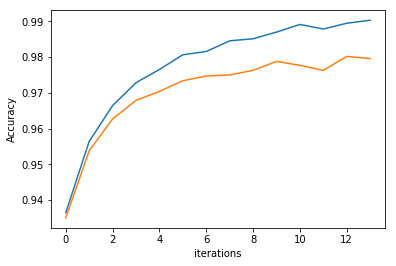

Train Accuracy: 0.99
Test Accuracy:0.98


In [14]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

As we can see we have successfully trained a Multi-Layer perceptron which was written in tensorflow with high validation accuracy!